In [ ]:
###not parameterized because the parameter is not standardlized. too much work to customize

In [2]:
import fasttext
import itertools
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

### Config

In [3]:
path = './data/'#the folder where your dataset is saved(assume train, val, test are saved under the same dir)
time = '24h'
train_path = path + 'train_' + time + '.txt'
val_path = path + 'val_' + time + '.txt'

In [4]:
epoch_para = [10, 15, 20, 25, 30]
lr_para = [0.01, 0.05, 0.1, 0.15, 0.2]
ws_para = [5, 10, 15, 20, 25,30]
x = []
x.append(epoch_para)
x.append(lr_para)
x.append(ws_para)
para_pair = list(itertools.product(*x))

### Data

In [5]:
text = []
with open( train_path,'r') as f:
    for line in f:
        text.append(line)

### Train

In [6]:
#tune the parameters for above and save these models
for epoch_, lr_, ws_ in para_pair:
    classifier = fasttext.supervised(train_path, 'model_{}_{}_{}_{}'.format(time, epoch_, lr_, ws_), epoch = epoch_, lr = lr_, ws = ws_, label_prefix='__label__')

In [7]:
#input the validation set and split the data and labels(now label and data comes together)
def readin_split(path):
    '''
    path: get the val/test set
    return: list of texts, corresponding labels
    '''
    text_val = []
    with open(path,'r') as f:
        for line in f:
            text_val.append(line)

    labels_val = []
    for i in range(len(text_val)):
        temp = text_val[i].strip('\n').split('__')
        text_val[i] = temp[0]
        labels_val.append(temp[-1])
    return text_val, labels_val

In [8]:
text_val, label_val = readin_split(val_path)

In [9]:
text_val[0]

'date # # # am chest portable ap clip number reason central line placement admitting diagnosis acute myocardial infarctionsepsis hospital medical condition # # year old man with as mr and new onset cp reason for this examination central line placement final report history as mr and newonset chest pain central line placement chest single ap view extreme left costophrenic angle excluded from film status post sternotomy with mild cardiomegaly the aorta is calcified minimal upper zone redistribution there is patchy increased opacity at both bases question atelectasis or early chf an early infiltrate is considered less likely no rightsided effusion is present no gross left effusion is seen a left subclavian central line is present tip at expected junction with right subclavian and innominate no pneumothorax is detected ccu nursing progress note # # # # # # # # # # yo male w extensive cardiac hx admitted from osh for cellulitis orchitis sepsis cb nstemi at osh pt transferred to hospital for 

In [10]:
label_val[0] #for calculating auc

'LIVE'

### Select

In [11]:
folder_li = filelist=os.listdir('/Users/leilei/Documents/DS1011Project')
folder_li = [i for i in folder_li if i.endswith('.bin')]

In [12]:
model_li = []
for path in folder_li: #the models' name corresponding to the name of the path
    model = fasttext.load_model(path, label_prefix='__label__')
    model_li.append(model)

In [13]:
binary_label_val = [0 if i == 'LIVE' else 1 for i in label_val]

In [14]:
score = []
num = 0
for i in tqdm(model_li):
    predict_list = i.predict(text_val)
    #print(num)
    num += 1
    predict_list = list(itertools.chain.from_iterable(predict_list))
    binary_predict_li = [0  if i == 'LIVE' else 1 for i in predict_list ]
    score.append(roc_auc_score(binary_label_val, binary_predict_li))

100%|██████████| 150/150 [03:29<00:00,  1.40s/it]


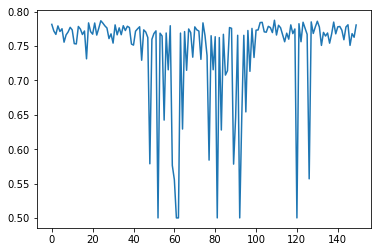

In [15]:
plt.plot(score)
plt.show();

In [16]:
para_pair_df = pd.DataFrame(para_pair)
para_pair_df.columns = ['epoch_para', 'lr_para', 'ws_para']
para_pair_df['score'] = score

In [17]:
para_pair_df[(para_pair_df.epoch_para == 10)&(para_pair_df.ws_para ==5)]

,epoch_para,lr_para,ws_para,score
0,10,0.01,5,0.781625
6,10,0.05,5,0.755744
12,10,0.10,5,0.753170
18,10,0.15,5,0.783791
24,10,0.20,5,0.786921


In [ ]:
### though it didn't take avg(seems the minimum), cause for two types, there are a few results, 
###which the below result only takes part of it. but here just have an idea

In [18]:
max(score)

0.78765048038322616

In [19]:
para_pair_df.to_csv('performance_{}.csv'.format(time))

### light visual

In [20]:
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=para_pair_df.score,x=para_pair_df.epoch_para,y=para_pair_df.lr_para,colorscale='rgb(50, 204, 153)')
data=[trace]
py.iplot(data, filename='epoch_lr_para',image_width=800, image_height=200)

In [21]:
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=para_pair_df.score,x=para_pair_df.epoch_para,y=para_pair_df.ws_para,colorscale='rgb(50, 204, 153)')
data=[trace]
py.iplot(data, filename='epoch_ws_para',image_width=800, image_height=200)

In [23]:
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=para_pair_df.score,x=para_pair_df.ws_para,y=para_pair_df.lr_para,colorscale='rgb(50, 204, 153)')
data=[trace]
py.iplot(data, filename='epoch_lr_para',image_width=800, image_height=200)

In [ ]:
therefore, go with epoch == 25 - 30,或者10, learning rate 0.05, ws = 20. and now train new combination(see around where increase color)

### retrain and test

In [24]:
#tune the parameters for above and save these models
epoch_para = [25,27,29, 31] #3
lr_para = [0.03,0.05,0.07] #3
ws_para = [18,20,22,24]#7
x = []
x.append(epoch_para)
x.append(lr_para)
x.append(ws_para)
para_pair_new = list(itertools.product(*x))
para_pair_new = [i for i in para_pair_new if i not in para_pair] 
#therefore avoid retrain and easy to get the score
#previously has to find the missing because filtering use the original list

In [25]:
for epoch_, lr_, ws_ in para_pair_new:
    classifier = fasttext.supervised(train_path, 'model_{}_{}_{}_{}'.format(time,epoch_, lr_, ws_), epoch = epoch_, lr = lr_, ws = ws_, label_prefix='__label__')

In [26]:
### don't use this, becasue if the above has run, the combination won't be added, but don't know which one is missing
folder_li2 = os.listdir('/Users/leilei/Documents/DS1011Project')
folder_li2 = [i for i in folder_li2 if (i.endswith('.bin')) and (i not in folder_li)]
model_li_new = []
for path in folder_li2: #the models' name corresponding to the name of the path
    model = fasttext.load_model(path, label_prefix='__label__')
    model_li_new.append(model)

In [27]:
len(model_li_new),len(para_pair_new),len(folder_li2)

(47, 47, 47)

In [28]:
score_new = []
for i in tqdm(model_li_new):
    predict_list = i.predict(text_val)
    predict_list = list(itertools.chain.from_iterable(predict_list))
    binary_predict_li = [0  if i == 'LIVE' else 1 for i in predict_list ]
    score_new.append(roc_auc_score(binary_label_val, binary_predict_li))

100%|██████████| 47/47 [00:46<00:00,  1.00it/s]


In [29]:
max(score), max(score_new)

(0.78765048038322616, 0.78889409962212631)

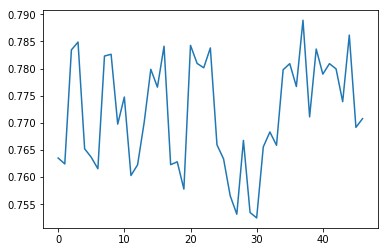

In [30]:
plt.plot(score_new)
plt.show();

In [31]:
np.where(score_new ==max(score_new))

(array([37]),)

In [32]:
para_pair_new[37]

(31, 0.03, 22)

In [33]:
para_pair_df_new = pd.DataFrame(para_pair_new)
para_pair_df_new.columns = ['epoch_para', 'lr_para', 'ws_para']
para_pair_df_new['score'] = score_new

In [34]:
para_pair_df_new.to_csv('performance_{}_2.csv'.format(time))

In [ ]:
#guess: when the time is longer, the optimum range of window size needs to be longer as the length of the notes.
#not really, the best is 5